In [4]:
import pandas as pd

# 加载数据
train = pd.read_csv('house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('house-prices-advanced-regression-techniques/test.csv')
test_price = pd.read_csv('house-prices-advanced-regression-techniques/sample_submission.csv')

#处理数据
all_features = pd.concat((train.iloc[:, 1:-1], test.iloc[:, 1:]))# 训练集最后一列price和第一列if不需要，删去；测试集第一列id也不需要，两个数据按列方向拼合在一起，否则axis=1

# 将训练集和测试集里面的数字跳出来，进行归一化以及将NA的值变成0
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x-x.mean())/(x.std()))
all_features[numeric_features] = all_features[numeric_features].fillna(0)

# 将分类的数据变为one-hot编码，dummy_na这意味着对于每个缺失值的分类列，将创建一个附加列来指示该值是否缺失。
all_features = pd.get_dummies(all_features, dummy_na=True)# 对于数字数据，它不会改变或影响数字列

(all_features.head(), all_features.shape)

(   MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
 0    0.067320    -0.184443 -0.217841     0.646073    -0.507197   1.046078   
 1   -0.873466     0.458096 -0.072032    -0.063174     2.187904   0.154737   
 2    0.067320    -0.055935  0.137173     0.646073    -0.507197   0.980053   
 3    0.302516    -0.398622 -0.078371     0.646073    -0.507197  -1.859033   
 4    0.067320     0.629439  0.518814     1.355319    -0.507197   0.947040   
 
    YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  SaleType_Oth  \
 0      0.896679    0.523038    0.580708    -0.29303  ...         False   
 1     -0.395536   -0.569893    1.177709    -0.29303  ...         False   
 2      0.848819    0.333448    0.097840    -0.29303  ...         False   
 3     -0.682695   -0.569893   -0.494771    -0.29303  ...         False   
 4      0.753100    1.381770    0.468770    -0.29303  ...         False   
 
    SaleType_WD  SaleType_nan  SaleCondition_Abnorml  SaleCondition_AdjLand  \

处理完数据，将数据集拆分并且转化为张量

此处有版本问题，pandas在转换的时候不同，新版本转换成true-false编码 老版本转换成0-1，导致下面报错，故增加了astype(float)先将bool变为float

In [5]:
import torch
n_train = train.shape[0]

train_features = torch.tensor(all_features[:n_train].values.astype(float), dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values.astype(float), dtype=torch.float32)
train_labels = torch.tensor(train.SalePrice.values.reshape(-1, 1), dtype=torch.float32)# pd检索不仅仅可以是使用['']的方式，也可以使用.这样的方法

(train_features.shape,test_features.shape,train_labels.shape)

(torch.Size([1460, 330]), torch.Size([1459, 330]), torch.Size([1460, 1]))

准备开始训练模型

In [6]:
from torch import nn

loss = nn.MSELoss()
in_features = train_features.shape[1]

def init_weights(m):# 初始化线性层的权重
    if type(m) == nn.Linear:# 使用m表示模块（layer/module）,如果这个模块是线性层 (nn.Linear)，则使用Xavier进行权重初始化
        nn.init.xavier_normal_(m.weight)# 这里使用 nn.init.xavier_normal 函数

def get_net(dropout): # 构建一个模型
    net = nn.Sequential(nn.Linear(in_features, 32), nn.ReLU(), nn.Dropout(dropout), nn.Linear(32, 1))
    net.apply(init_weights)# 无需设置b，因为nn.Linear默认设置有偏差bias
    return net

def log_rmse(net, features, labels):# 消除量纲，更关心相对误差，房价的值差异较大，做了对数处理然后MSE，再进行开方变成RMSE
    clipped_preds = torch.clamp(net(features), 1, float('inf')) # 允许你将张量的值限制在指定范围内，小于1的都放置为等于1
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item() # Returns the value of this tensor as a standard Python number.

创建一个 torch.utils.data.TensorDataset 实例，这个实例将输入的数据数组转换为 PyTorch 数据集。TensorDataset 是 PyTorch 提供的一个用于处理张量数据的数据集类。
使用 torch.utils.data.DataLoader 创建一个数据加载器，它将数据集划分为批次，并允许你按照指定的 batch_size 和 shuffle 参数来加载数据。这个数据加载器将在训练模型时用于迭代访问数据。

In [7]:
def train(net, train_features, train_labels, test_features, test_labels, num_epochs, learning_rate, weight_dacay, batch_size):
    train_ls, test_ls = [],[]
    train_dataset = torch.utils.data.TensorDataset(train_features, train_labels)
    train_iter = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_dacay)# 一个比较平滑的SGD，对于学习率不那么敏感
    for epoch in range(num_epochs):
        for X,y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

在训练集中使用k折交叉验证的方式进行计算，即先做k折交叉验证，再进行模型训练(batch次)，得到train、test的MSE，最后取

In [8]:
from sklearn.model_selection import KFold
from d2l import torch as d2l

def k_fold(k, dropout, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum =0, 0
    Kf = KFold(n_splits=k, shuffle=True, random_state=7)# 使用K折验证产生迭代器
    net = get_net(dropout)
    for fold, (train_idx, val_idx) in enumerate(Kf.split(X_train)):# enumerate(kf.split(X))会迭代每个折叠，并在每个迭代中返回一个元组 (train_idx, val_idx)，其中 train_idx 是训练集的索引，val_idx 是验证集的索引。通过使用 enumerate 函数，我们还可以跟踪当前是第几折，并将其打印出来。
        train_ls, valid_ls = train(net, X_train[train_idx], y_train[train_idx], X_train[val_idx], y_train[val_idx], num_epochs, learning_rate, weight_decay, batch_size)
        train_l_sum += train_ls[-1]# 最后一轮拟合后的训练集log_rmse和验证集log_rmse
        valid_l_sum += valid_ls[-1]
        if fold == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls], xlabel='epoch', ylabel='rmse', xlim=[1,num_epochs], legend=['train', 'valid'], yscale='log') # 第一折的图像
        print(f'fold{fold+1}, train log rmse {float(train_ls[-1]):f},valid log rmse {float(valid_ls[-1]):f}')# 五折，五次输出
    return train_l_sum / k,valid_l_sum / k# 每一折加一次最后一轮拟合后的训练集和测试集，故最后输出要除以k

fold1, train log rmse 0.168603,valid log rmse 0.165056
fold2, train log rmse 0.140196,valid log rmse 0.140062
fold3, train log rmse 0.132160,valid log rmse 0.127363
fold4, train log rmse 0.125639,valid log rmse 0.150853
fold5, train log rmse 0.118274,valid log rmse 0.174690
fold6, train log rmse 0.124895,valid log rmse 0.125262
fold7, train log rmse 0.126393,valid log rmse 0.095857
fold8, train log rmse 0.123652,valid log rmse 0.123032
8-折验证：平均训练log rmse:0.132477,平均验证log rmse：0.137772


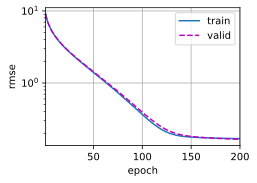

In [21]:
k, num_epochs, lr, weight_decay, dropout, batch_size = 8, 200, 0.005, 0, 0, 64

train_l, valid_l = k_fold(k, dropout, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print(f'{k}-折验证：平均训练log rmse:{float(train_l):f},平均验证log rmse：{float(valid_l):f}')

**学习率越高，拟合速度越快，但可能过快造成波动
做Xavier初始化可以使得初始值更合理，缩短拟合路径
Dropout 是为了过拟合，可能会减慢模型的训练速度
权重衰减（通常称为 L2 正则化）是为了过拟合，如果正则化项设置得太高，它可能会使模型难以拟合数据，从而减慢学习过程
迭代次数越多，拟合也会越好，但也有可能会波动**